This notebook is designed to explore some interesting features avaliable through BPt, specifically loading Data_Files and using custom loaders.

This example will require some extra optional libraries, including nibabel and nilearn! Note: while nilearn is not imported, when trying to import Connectivity, if nilearn is not installed, this will give an ImportError.

We will also use fake data for this example - so no special datasets required!

In [1]:
from BPt import BPt_ML
import nibabel as nib
import numpy as np
import pandas as pd
import os

## Let's start by saving some fake surface time-series data, and also some fake just surface data.

In [2]:
X = np.random.random(size = (20, 100, 10242))
os.makedirs('fake_time_data', exist_ok=True)

for x in range(len(X)):
    np.save('fake_time_data/' + str(x) + '_lh', X[x])
for x in range(len(X)):
    np.save('fake_time_data/' + str(x) + '_rh', X[x])
    
X = np.random.random(size = (20, 10242))
os.makedirs('fake_surf_data', exist_ok=True)

for x in range(len(X)):
    np.save('fake_surf_data/' + str(x) + '_lh', X[x])
for x in range(len(X)):
    np.save('fake_surf_data/' + str(x) + '_rh', X[x])

### In this expiriment we will load both the timeseries and the just surface data

In [3]:
ML = BPt_ML(log_dr=None, verbose=True)

timeseries_dr = 'fake_time_data/'
files = os.listdir(timeseries_dr)
lh_timeseries = [timeseries_dr + f for f in files if '_lh' in f]
rh_timeseries = [timeseries_dr + f for f in files if '_rh' in f]

surf_dr = 'fake_surf_data/'
files = os.listdir(surf_dr)
lh_surf = [surf_dr + f for f in files if '_lh' in f]
rh_surf = [surf_dr + f for f in files if '_rh' in f]

subjects = [str(i) for i in range(20)]

df = pd.DataFrame()

df['lh_timeseries'] = lh_timeseries
df['rh_timeseries'] = rh_timeseries

df['lh_surf'] = lh_surf
df['rh_surf'] = rh_surf

df['src_subject_id'] = subjects
df['target'] = np.random.randint(2, size=20)


ML.Load_Data_Files(df = df,
                   load_func = np.load,
                   drop_keys = ['target'])

ML.Load_Targets(df = df, col_name='target', data_type='b')
ML.Load_Strat(df = df, col_name='target')
ML.Train_Test_Split(test_size=0)

exp_name = My_Exp
log_dr = None
existing_log = append
verbose = True
exp log dr setup at: None
log file at: None
Default params set:
notebook = True
use_abcd_subject_ids = False
low memory mode = False
strat_u_name = _Strat
random state = 534
n_jobs = 1
dpi = 100
mp_context = loky
BPt_ML object initialized
Setting default load params, as they have not been set!

Default load params set within self.default_load_params.
----------------------
dataset_type: basic
subject_id: src_subject_id
eventname: None
eventname_col: eventname
overlap_subjects: False
merge: inner
na_values: ['777', '999']
drop_na: True
drop_or_na: drop

To change the default load params, call self.Set_Default_Load_Params()

Loading from df or files

Dropped 1 columns per passed drop_keys argument
Loading from df or files
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loading: target

Loaded Sh

### This will assume you have some saved parcellations in the relevant space, i.e., we saved fake fsaverage5 surface data, so we will load in the desikan parcellations

In [4]:
from BPt.extensions import SurfLabels, Connectivity, Networks

base = '/home/sage/work/Parcel_Search/Existing_Parcels/'
desikan_lh = base + 'lh.aparc.annot'
desikan_rh = base + 'rh.aparc.annot'

t_surf_rois_lh = SurfLabels(labels = desikan_lh,
                            vectorize = False)
t_surf_rois_rh = SurfLabels(labels = desikan_rh,
                            vectorize = False)

connectivity = Connectivity(vectorize=True, discard_diagonal=False)

surf_rois_lh = SurfLabels(labels = desikan_lh)
surf_rois_rh = SurfLabels(labels = desikan_rh)

### Try just loading the left hemisphere surface data

In [5]:
from BPt import Problem_Spec, Loader, Model_Pipeline, Feat_Selector, Feat_Importance

problem_spec = Problem_Spec(problem_type = 'binary',
                            scope = 'lh_surf')

loaders = Loader(surf_rois_lh, scope='lh_surf')

model_pipeline = Model_Pipeline(loaders=loaders,
                                feat_selectors=Feat_Selector('univariate selection'),
                                feat_importances=Feat_Importance('shap'))

results = ML.Evaluate(model_pipeline, problem_spec,
                      return_models=True, feat_importances='base')

len(results['models'])

[Imputer(obj='mean', scope='float'), Imputer(obj='median', scope='cat')]
Passed default imputers, setting to: None
Model(obj='linear')
Passed default model, setting to: None
Setting default ML verbosity settings!
Note, if the following values are not desired, call self.Set_Default_ML_Verbosity()
Default ML verbosity set within self.default_ML_verbosity.
----------------------
save_results: False
progress_bar: True
progress_loc: None
pipeline_verbose: False
compute_train_score: False
show_init_params: True
fold_name: False
time_per_fold: False
score_per_fold: False
fold_sizes: False
best_params: False
best_params_score: False
save_to_logs: False
flush: False

problem_spec scorer ==  default, setting as: ['matthews', 'roc_auc', 'balanced_accuracy']
Model_Pipeline
--------------
loaders=\
Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot'),
       scope='lh_surf')

imputers=\
[Imputer(obj='mean', scope='float'),
 Imputer(obj='median', scope='cat')




Validation Scores
_________________
Scorer:  matthews
Mean Validation score:  -0.4202151986793378
Micro Std in Validation score:  0.30473534623231524
Macro Std in Validation score:  0.14949390166781468

Scorer:  roc_auc
Mean Validation score:  0.25555555555555554
Micro Std in Validation score:  0.1461438493107323
Macro Std in Validation score:  0.055555555555555566

Scorer:  balanced_accuracy
Mean Validation score:  0.3194444444444444
Micro Std in Validation score:  0.1310275157230084
Macro Std in Validation score:  0.06944444444444442



6

In [6]:
ex_pipe = results['models'][0]
for step in ex_pipe.steps:
    print(step)

('Custom 0', Loader_Wrapper(background_label=0,
               file_mapping={0: <BPt.helpers.Data_File.Data_File object at 0x7f6f4a08b4d0>,
                             1: <BPt.helpers.Data_File.Data_File object at 0x7f6f4a08b390>,
                             2: <BPt.helpers.Data_File.Data_File object at 0x7f6f4a08bcd0>,
                             3: <BPt.helpers.Data_File.Data_File object at 0x7f6f4a08bdd0>,
                             4: <BPt.helpers.Data_File.Data_File object at 0x7f6f4a08bd90>,
                             5: <BPt.helpe...
                             28: <BPt.helpers.Data_File.Data_File object at 0x7f6f49814450>,
                             29: <BPt.helpers.Data_File.Data_File object at 0x7f6f49814490>, ...},
               labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot',
               mask=None, strategy='mean', vectorize=True, wrapper_inds=[0],
               wrapper_transformer=SurfLabels(labels='/home/sage/work/Parcel_Search/Existi

In [7]:
results['FIs'][0]

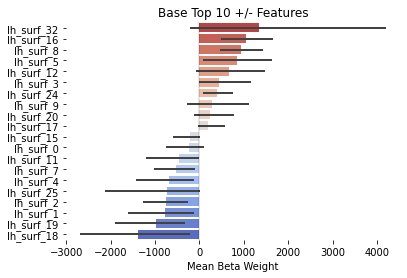

In [8]:
ML.Plot_Global_Feat_Importances()

In [9]:
problem_spec = Problem_Spec(problem_type = 'binary',
                            scope = '_surf')

loaders = [Loader(surf_rois_lh, scope='lh_surf'),
           Loader(surf_rois_rh, scope='rh_surf')]

model_pipeline = Model_Pipeline(loaders=loaders,
                                feat_importances=Feat_Importance('shap'))

results = ML.Evaluate(model_pipeline, problem_spec, return_models=True)

for step in results['models'][0].steps:
    print(step)

[Imputer(obj='mean', scope='float'), Imputer(obj='median', scope='cat')]
Passed default imputers, setting to: None
Model(obj='linear')
Passed default model, setting to: None
problem_spec scorer ==  default, setting as: ['matthews', 'roc_auc', 'balanced_accuracy']
Model_Pipeline
--------------
loaders=\
[Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot'),
       scope='lh_surf'),
 Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/rh.aparc.annot'),
       scope='rh_surf')]

imputers=\
[Imputer(obj='mean', scope='float'),
 Imputer(obj='median', scope='cat')]

model=\
Model(obj='linear')

param_search=\
None



Problem_Spec
------------
problem_type = binary
target = target
scorer = ['matthews', 'roc_auc', 'balanced_accuracy']
weight_scorer = False
scope = _surf
subjects = all
len(subjects) = 20 (before overlap w/ train/test subjects)
n_jobs = 1
random_state = 534

Evaluate Params
---------------
splits = 3
n_repeats = 2




Validation Scores
_________________
Scorer:  matthews
Mean Validation score:  -0.22727167944559246
Micro Std in Validation score:  0.24798332982305082
Macro Std in Validation score:  0.0717161238900369

Scorer:  roc_auc
Mean Validation score:  0.4398148148148149
Micro Std in Validation score:  0.18048906658024153
Macro Std in Validation score:  0.08611111111111117

Scorer:  balanced_accuracy
Mean Validation score:  0.38055555555555554
Micro Std in Validation score:  0.13588416454038896
Macro Std in Validation score:  0.041666666666666685

('Custom 0', Loader_Wrapper(background_label=0,
               file_mapping={0: <BPt.helpers.Data_File.Data_File object at 0x7f6f497964d0>,
                             1: <BPt.helpers.Data_File.Data_File object at 0x7f6f49796e90>,
                             2: <BPt.helpers.Data_File.Data_File object at 0x7f6f49796a10>,
                             3: <BPt.helpers.Data_File.Data_File object at 0x7f6f49796dd0>,
                             4: <BPt

### Load everything

In [10]:
from BPt import Pipe
problem_spec.scope = 'all'

loaders = [Loader(surf_rois_lh, scope='lh_surf'),
           Loader(surf_rois_rh, scope='rh_surf'),
           Loader(Pipe([t_surf_rois_lh, connectivity]), scope='lh_timeseries'),
           Loader(Pipe([t_surf_rois_rh, connectivity]), scope='rh_timeseries')]

model_pipeline = Model_Pipeline(loaders=loaders)
results = ML.Evaluate(model_pipeline, problem_spec, return_models=True)

for step in results['models'][0].steps:
    print(step)

[Imputer(obj='mean', scope='float'), Imputer(obj='median', scope='cat')]
Passed default imputers, setting to: None
Model(obj='linear')
Passed default model, setting to: None
problem_spec scorer ==  default, setting as: ['matthews', 'roc_auc', 'balanced_accuracy']
Model_Pipeline
--------------
loaders=\
[Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot'),
       scope='lh_surf'),
 Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/rh.aparc.annot'),
       scope='rh_surf'),
 Loader(obj=Pipe([SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot',
           vectorize=False), Connectivity(vectorize=True)]),
       params=[0, 0], scope='lh_timeseries'),
 Loader(obj=Pipe([SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/rh.aparc.annot',
           vectorize=False), Connectivity(vectorize=True)]),
       params=[0, 0], scope='rh_timeseries')]

imputers=\
[Imputer(obj='mean', scope




Validation Scores
_________________
Scorer:  matthews
Mean Validation score:  -0.22727167944559246
Micro Std in Validation score:  0.24798332982305082
Macro Std in Validation score:  0.0717161238900369

Scorer:  roc_auc
Mean Validation score:  0.4398148148148149
Micro Std in Validation score:  0.18048906658024153
Macro Std in Validation score:  0.08611111111111117

Scorer:  balanced_accuracy
Mean Validation score:  0.38055555555555554
Micro Std in Validation score:  0.13588416454038896
Macro Std in Validation score:  0.041666666666666685

('Custom 0', Loader_Wrapper(background_label=0,
               file_mapping={0: <BPt.helpers.Data_File.Data_File object at 0x7f6fc82c8a50>,
                             1: <BPt.helpers.Data_File.Data_File object at 0x7f6fc8306a90>,
                             2: <BPt.helpers.Data_File.Data_File object at 0x7f6f6f5ec250>,
                             3: <BPt.helpers.Data_File.Data_File object at 0x7f6f6f5ec5d0>,
                             4: <BPt

In [11]:
problem_spec.scope = 'timeseries'

loaders = [Loader(surf_rois_lh, scope='lh_timeseries'),
           Loader(surf_rois_rh, scope='rh_timeseries')]

model_pipeline = Model_Pipeline(loaders=loaders)
results = ML.Evaluate(model_pipeline, problem_spec, return_models=True)

for step in results['models'][0].steps:
    print(step)

[Imputer(obj='mean', scope='float'), Imputer(obj='median', scope='cat')]
Passed default imputers, setting to: None
Model(obj='linear')
Passed default model, setting to: None
problem_spec scorer ==  default, setting as: ['matthews', 'roc_auc', 'balanced_accuracy']
Model_Pipeline
--------------
loaders=\
[Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/lh.aparc.annot'),
       scope='lh_timeseries'),
 Loader(obj=SurfLabels(labels='/home/sage/work/Parcel_Search/Existing_Parcels/rh.aparc.annot'),
       scope='rh_timeseries')]

imputers=\
[Imputer(obj='mean', scope='float'),
 Imputer(obj='median', scope='cat')]

model=\
Model(obj='linear')

param_search=\
None



Problem_Spec
------------
problem_type = binary
target = target
scorer = ['matthews', 'roc_auc', 'balanced_accuracy']
weight_scorer = False
scope = timeseries
subjects = all
len(subjects) = 20 (before overlap w/ train/test subjects)
n_jobs = 1
random_state = 534

Evaluate Params
---------------
splits 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars





Validation Scores
_________________
Scorer:  matthews
Mean Validation score:  0.0
Micro Std in Validation score:  0.0
Macro Std in Validation score:  0.0

Scorer:  roc_auc
Mean Validation score:  0.6777777777777778
Micro Std in Validation score:  0.1330243333042072
Macro Std in Validation score:  0.10370370370370374

Scorer:  balanced_accuracy
Mean Validation score:  0.5
Micro Std in Validation score:  0.0
Macro Std in Validation score:  0.0

('Custom 0', Loader_Wrapper(background_label=0,
               file_mapping={0: <BPt.helpers.Data_File.Data_File object at 0x7f6f48645e50>,
                             1: <BPt.helpers.Data_File.Data_File object at 0x7f6f486450d0>,
                             2: <BPt.helpers.Data_File.Data_File object at 0x7f6f48645ed0>,
                             3: <BPt.helpers.Data_File.Data_File object at 0x7f6f48645950>,
                             4: <BPt.helpers.Data_File.Data_File object at 0x7f6f48645e90>,
                             5: <BPt.helpe